In [1]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from models import *

In [2]:
# batch size, size of image, size of latent vector z
IMG_SZ = 256
N_Z = 100
N_CHANNELS = 3

num_channels = 3


In [3]:
z_sequential = torch.load("z_seq_sequential_9.13.pt")
norm_z, z_mean, z_max = normalize_sequential(z_sequential)
real_z = torch.tensor(z_sequential[10])

torch.Size([1, 100])
torch.Size([1, 100])


In [4]:
#g_state_dict = torch.load("netG_updown9.8.torch", map_location=lambda storage, loc: storage)
g_state_dict = torch.load("netG_updown9.13.torch")
g = DCGAN_G(IMG_SZ, N_Z, N_CHANNELS, 64, 1).cuda(); 
g.load_state_dict(g_state_dict)
g.eval()

DCGAN_G(
  (features): Sequential(
    (0): DeconvBlock(
      (conv): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (1): DeconvBlock(
      (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (2): DeconvBlock(
      (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (3): DeconvBlock(
      (conv): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (re

In [5]:
next_frame = g(pad_z(real_z.unsqueeze(0)).cuda())

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [6]:
next_frame = next_frame.squeeze(0).permute(1,2,0).cpu().detach().numpy()
next_frame = np.uint8(next_frame*255)

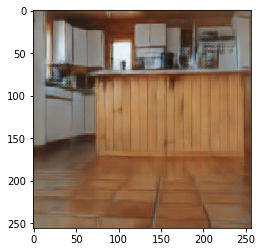

In [7]:
plt.imshow(next_frame)

In [8]:
START_Z = real_z # grab random latent to start w

# rnn takes tiny tiny amount of time. Generator takes .25 seconds each pass.

class test_env(gym.Env):
    def __init__(self):
        
        self.lstm = LSTM()
        self.generator = DCGAN_G(IMG_SZ, N_Z, N_CHANNELS, 64, 1)

        self.lstm.load_state_dict(torch.load("lstm_updown9.13.torch", map_location=lambda storage, loc: storage))
        
        # I believe batch norm stuff was throwing off load. Changed strict to False fixed it
        self.generator.load_state_dict(torch.load("netG_updown9.13.torch", 
                                                  map_location=lambda storage, loc: storage))
        
        #detrackify(self.generator)
        # THese were messing it up!
        #self.lstm.eval(); self.generator.eval()
        
        # spaces
        self.action_space = gym.spaces.Box(np.array([-1, 0, 0]), np.array([1, 1, 1]))
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(IMG_SZ, IMG_SZ, 3),dtype=np.uint8)

        self._action_set = [0,1,2,3,4,5]
        #self.action_space = spaces.Discrete(len(self._action_set))
        
        self.reset()

    def reset(self):
        self.z = START_Z
        self.hidden = make_hidden(1, False) # Number of seqs, cuda available
        

    def step(self, action):
        action = ACTION_TO_VALUE[action]
        
        with torch.no_grad():
            action = torch.FloatTensor([action])
            x = torch.cat([action, self.z], dim=0)# only 0 dim here anyways
            x.unsqueeze_(0).unsqueeze_(0) # padding to fit into lstm expectation
            input_package = [x, self.hidden]
            mdn_coefs, self.hidden = self.lstm(input_package)

            # Moving view acrobatics out here to help ONNX
            mdn_coefs[0] = mdn_coefs[0].view(x.size(0), x.size(1), N_GAUSSIANS, N_IN)
            mdn_coefs[1] = mdn_coefs[1].view(x.size(0), x.size(1), N_GAUSSIANS, N_IN)
            mdn_coefs[2] = mdn_coefs[2].view(x.size(0), x.size(1), N_GAUSSIANS, N_IN)

            next_z = sample_mdn(mdn_coefs)[1:] # First item is predicted action
            next_z = torch.tensor(next_z)
            next_frame = self.generator(pad_z(next_z.unsqueeze(0))) # G expects size (1,100,1,1). pad_z puts two ones at end.
            
            self.z = next_z
            # prep frame to show numpy

            next_frame = next_frame.squeeze(0).permute(1,2,0).numpy()
            next_frame = np.uint8(next_frame*255)
            
            return next_frame, 1, False, "info"

    def render(self): # pylint: disable=arguments-differ
        """ Rendering """
        
    def get_action_meanings(self):
        return [ACTION_MEANING[i] for i in self._action_set]
    
    def get_keys_to_action(self):
        KEYWORD_TO_KEY = {
            'UP':      ord('w'),
            'DOWN':    ord('s'),
            'LEFT':    ord('a'),
            'RIGHT':   ord('d'),
            'FIRE':    ord(' '),
        }

        keys_to_action = {}

        for action_id, action_meaning in enumerate(self.get_action_meanings()):
            keys = []
            for keyword, key in KEYWORD_TO_KEY.items():
                if keyword in action_meaning:
                    keys.append(key)
            keys = tuple(sorted(keys))

            assert keys not in keys_to_action
            keys_to_action[keys] = action_id
        return keys_to_action
    
ACTION_MEANING = {
    0 : "NOOP",
    1 : "FIRE",
    2 : "UP",
    3 : "RIGHT",
    4 : "LEFT",
    5 : "DOWN",
}

ACTION_TO_VALUE = {
    0 : 0.0,
    2 : .65,
    5 : -.65
}

In [10]:
env = test_env()
env.reset()
obs, reward, done, info = env.step(0.0); obs.shape

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(256, 256, 3)

In [15]:
env.observation_space.shape[0], env.observation_space.shape[1]

(256, 256)

In [21]:
#env = gym.make("MontezumaRevengeNoFrameskip-v4")

env = test_env()
play(env, zoom = 2, fps=3)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


C:\Users\rugilman\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [85]:
pygame.quit()

In [9]:
import gym
import pygame
import sys
import time
import matplotlib
try:
    matplotlib.use('GTK3Agg')
    import matplotlib.pyplot as plt
except Exception:
    pass


import pyglet.window as pw

from collections import deque
from pygame.locals import HWSURFACE, DOUBLEBUF, RESIZABLE, VIDEORESIZE
from threading import Thread

def display_arr(screen, arr, video_size, transpose):
    #arr_min, arr_max = arr.min(), arr.max()
    #arr = 255.0 * (arr - arr_min) / (arr_max - arr_min)
    pyg_img = pygame.surfarray.make_surface(arr.swapaxes(0, 1) if transpose else arr)
    pyg_img = pygame.transform.scale(pyg_img, video_size)
    screen.blit(pyg_img, (0,0))

def play(env, transpose=True, fps=30, zoom=None, callback=None, keys_to_action=None):

    obs_s = env.observation_space
    assert type(obs_s) == gym.spaces.box.Box
    assert len(obs_s.shape) == 2 or (len(obs_s.shape) == 3 and obs_s.shape[2] in [1,3])

    if keys_to_action is None:
        if hasattr(env, 'get_keys_to_action'):
            keys_to_action = env.get_keys_to_action()
        elif hasattr(env.unwrapped, 'get_keys_to_action'):
            keys_to_action = env.unwrapped.get_keys_to_action()
        else:
            assert False, env.spec.id + " does not have explicit key to action mapping, " + \
                          "please specify one manually"
    relevant_keys = set(sum(map(list, keys_to_action.keys()),[]))
    
    if transpose:
        video_size = env.observation_space.shape[1], env.observation_space.shape[0]
    else:
        video_size = env.observation_space.shape[0], env.observation_space.shape[1]

    if zoom is not None:
        video_size = int(video_size[0] * zoom), int(video_size[1] * zoom)

    pressed_keys = []
    running = True
    env_done = True

    screen = pygame.display.set_mode(video_size)
    clock = pygame.time.Clock()

    while running:
        if env_done:
            env_done = False
            obs = env.reset()
        else:
            action = keys_to_action.get(tuple(sorted(pressed_keys)), 0)
            prev_obs = obs
            obs, rew, env_done, info = env.step(action)
            if callback is not None:
                callback(prev_obs, obs, action, rew, env_done, info)
        if obs is not None:
            if len(obs.shape) == 2:
                obs = obs[:, :, None]
            if obs.shape[2] == 1:
                obs = obs.repeat(3, axis=2)
            display_arr(screen, obs, transpose=transpose, video_size=video_size)

        # process pygame events
        for event in pygame.event.get():
            # test events, set key states
            if event.type == pygame.KEYDOWN:
                if event.key in relevant_keys:
                    pressed_keys.append(event.key)
                elif event.key == 27:
                    running = False
            elif event.type == pygame.KEYUP:
                if event.key in relevant_keys:
                    pressed_keys.remove(event.key)
            elif event.type == pygame.QUIT:
                running = False
            elif event.type == VIDEORESIZE:
                video_size = event.size
                screen = pygame.display.set_mode(video_size)

        pygame.display.flip()
        clock.tick(fps)
    pygame.quit()


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


/usr/lib/python3/dist-packages/matplotlib/__init__.py:1403: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


GLXInfoException: pyglet requires an X server with GLX